In [1]:
import os
import yaml
import fsspec
import itertools

import datamol as dm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mood.rct import get_experimental_configurations
from mood.dataset import MOOD_DATASETS, MOOD_REGR_DATASETS
from mood.metrics import Metric
from mood.utils import get_outlier_bounds
from mood.model import MOOD_ALGORITHMS
from mood.representations import MOOD_REPRESENTATIONS
from mood.splitter import MOOD_SPLITTERS
from mood.criteria import MOOD_CRITERIA

/home/cas/local/conda/envs/mood/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Simple custom loader to ignore Python tags

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Load the data

In [3]:
SUBDIR = "20230225"
BASE_PATH = "gs://experiments-output/mood-v2/results/YAML/RCT/"
N_RCT_TRIALS = 250

In [4]:
def get_result_paths_for_dataset(dataset):
    pattern = dm.fs.join(BASE_PATH, SUBDIR, f"*{dataset}*.yaml")
    paths = dm.fs.glob(pattern)
    return paths


def find_missing(dataset, n: int = N_RCT_TRIALS):
    
    paths = get_result_paths_for_dataset(dataset)
    all_configs = get_experimental_configurations(dataset)[:n]
    indices = list(range(n))
    
    for path in paths: 
        
        path = dm.fs.get_basename(path)
        path = os.path.splitext(path)[0]
        
        config = path.split("_")[4:]
        config[-1] = int(config[-1])
        config = tuple(config)
        
        indices.remove(all_configs.index(config))
        
    return indices
        

for dataset in MOOD_DATASETS:
    missing = find_missing(dataset)
    print(f"Missing {len(missing)}/{N_RCT_TRIALS} of results for {dataset}: {missing}")

Missing 1/250 of results for DILI: [170]
Missing 4/250 of results for HIA: [29, 74, 78, 115]
Missing 3/250 of results for hERG: [16, 150, 229]
Missing 1/250 of results for HalfLife: [73]
Missing 1/250 of results for Caco-2: [123]
Missing 1/250 of results for Clearance: [183]
Missing 2/250 of results for Pgp: [64, 94]
Missing 2/250 of results for PPBR: [24, 66]
Missing 3/250 of results for BBB: [64, 206, 246]
Missing 3/250 of results for Lipophilicity: [1, 70, 232]
Missing 3/250 of results for CYP2C9: [55, 217, 220]


<div style="padding: 10px; background-color: #17a2b8; color: white;"><b>NOTE:</b> That some of the results are still missing, is expected. These are experiments that could not finish, e.g. due to OOM or because of sensitivity to the hyper-params, we didn't succeed to train a ensemble with best hyper-params found.</div>

In [5]:
def load_results(path):
    with fsspec.open(path, "r") as fd:
        data = yaml.load(fd, Loader=SafeLoaderIgnoreUnknown)
        data.pop("hparams")
    
    data.pop("criterion_final")

    # NOTE: Due to a bug, for some early workflows the seed in the YAML was faulty. 
    # Luckily, we can still extract the right seed from the filename
    if "trial_seed" not in data:
        data["trial_seed"] = data["seed"]
        data["seed"] = int(path[-6])
    
    # Add some additional information
    df = pd.DataFrame(data, index=[0])
    
    metric_cal = Metric.get_default_calibration_metric(data["dataset"])
    metric_prf = Metric.get_default_performance_metric(data["dataset"])
    
    df["metric_calibration"] = metric_cal.name
    df["metric_performance"] = metric_prf.name
    df["minimize_calibration"] = metric_cal.mode == "min"
    df["minimize_performance"] = metric_prf.mode == "min"
    
    df.columns = [col.replace(f"{metric_prf.name}_", "") for col in df.columns]
    df.columns = [col.replace(f"{metric_cal.name}_", "") for col in df.columns]
    return df


paths = [p for dataset in MOOD_DATASETS for p in get_result_paths_for_dataset(dataset)]
df_original = pd.concat(dm.utils.parallelized(load_results, paths, progress=True), ignore_index=True)
df_original.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2726/2726 [01:43<00:00, 26.25it/s]


,algorithm,criterion,dataset,representation,seed,test_calibration_0,test_calibration_1,test_calibration_2,test_calibration_final,test_performance_0,...,val_extra_pearson_2,val_extra_pearson_final,val_extra_r2_0,val_extra_r2_1,val_extra_r2_2,val_extra_r2_final,val_extra_spearman_0,val_extra_spearman_1,val_extra_spearman_2,val_extra_spearman_final
0,CORAL,Performance,DILI,ChemBERTa,2,0.189520,0.221250,0.260150,0.219933,0.785714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORAL,Distance Weighted Performance,DILI,ChemBERTa,1,0.492302,0.500334,0.480945,0.471713,0.770499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORAL,Calibration,DILI,Desc2D,6,0.066264,0.173510,0.173072,0.066264,0.403619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORAL,Distance Weighted Performance,DILI,Desc2D,3,0.518266,0.498849,0.476540,0.502780,0.863103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORAL,Distance Weighted Performance,DILI,Desc2D,1,0.283731,0.345310,0.282581,0.312234,0.864431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_original.groupby("dataset")[["test_performance_final", "test_calibration_final"]].describe()

test_performance_final                                       \
                               count         mean           std       min   
dataset                                                                     
BBB                            247.0     0.654433      0.154242  0.257759   
CYP2C9                         247.0     0.718323      0.118329  0.265066   
Caco-2                         249.0    61.127111    840.083697  0.389813   
Clearance                      249.0  2766.492817  43384.224846  0.542546   
DILI                           249.0     0.666993      0.142715  0.180861   
HIA                            246.0     0.678225      0.205260  0.058266   
HalfLife                       249.0   410.299862   6248.509544  0.101352   
Lipophilicity                  247.0   133.267452   1533.400756  0.439891   
PPBR                           248.0    77.028778    816.846625  0.479385   
Pgp                            248.0     0.741931      0.182119  0.106481   
hERG                           247.0     0.647915      0.152524  0.186499   

                                                            \
                    25%       50%       75%            max   
dataset                                                      
BBB            0.542578  0.671992  0.772441       0.933309   
CYP2C9         0.655373  0.751593  0.796334       0.878084   
Caco-2         0.609331  0.740919  0.831755   13232.986328   
Clearance      0.740388  0.826113  0.882111  684603.875000   
DILI           0.571024  0.700000  0.771429       0.899483   
HIA            0.510406  0.675253  0.874689       0.993902   
HalfLife       0.208818  0.301202  0.444265   98595.601562   
Lipophilicity  0.660241  0.765787  0.853027   22941.005859   
PPBR           0.628077  0.717888  0.869908   11986.520508   
Pgp            0.652853  0.815143  0.866134       0.964099   
hERG           0.558250  0.657867  0.767459       0.891884   

              test_calibration_final                                          \
                               count      mean       std       min       25%   
dataset                                                                        
BBB                            247.0  0.393514  0.236961  0.003228  0.233752   
CYP2C9                         247.0  0.199767  0.118213  0.000000  0.135371   
Caco-2                         245.0  0.124403  0.323552 -1.000000 -0.069079   
Clearance                      248.0  0.150464  0.363646 -1.000000 -0.040521   
DILI                           248.0  0.284395  0.116867  0.000000  0.239069   
HIA                            245.0  0.464240  0.343009  0.001822  0.170967   
HalfLife                       247.0  0.267510  0.386503 -1.000000 -0.013231   
Lipophilicity                  240.0  0.193100  0.338329 -1.000000  0.004047   
PPBR                           244.0  0.185218  0.332354 -1.000000 -0.027547   
Pgp                            248.0  0.316107  0.135503  0.000000  0.239199   
hERG                           246.0  0.386527  0.217498  0.000000  0.215891   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.303446  0.620749  0.978499  
CYP2C9         0.186911  0.252430  0.518341  
Caco-2         0.055957  0.185912  1.000000  
Clearance      0.082476  0.244880  1.000000  
DILI           0.261882  0.326251  0.994068  
HIA            0.313232  0.824353  0.985085  
HalfLife       0.096011  0.568715  1.000000  
Lipophilicity  0.083587  0.181746  1.000000  
PPBR           0.112475  0.303813  1.000000  
Pgp            0.288584  0.405337  0.985813  
hERG           0.334706  0.565638  0.994660

In [7]:
df_original.groupby("dataset")[["val_performance_final", "val_calibration_final"]].describe()

val_performance_final                                     \
                              count        mean          std       min   
dataset                                                                  
BBB                           247.0    0.705882     0.178038  0.199826   
CYP2C9                        247.0    0.752671     0.118994  0.291647   
Caco-2                        249.0   24.963457   307.889423  0.327273   
Clearance                     249.0  200.735574  2881.352031  0.498429   
DILI                          249.0    0.726717     0.160575  0.227582   
HIA                           246.0    0.741672     0.211834  0.000000   
HalfLife                      249.0   10.218301    75.368464  0.091070   
Lipophilicity                 247.0   38.222384   491.162304  0.392792   
PPBR                          248.0   65.111483   723.830149  0.362644   
Pgp                           248.0    0.750406     0.211740  0.000000   
hERG                          247.0    0.716767     0.183718  0.200990   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.559409  0.736951  0.861850      0.975450   
CYP2C9         0.706931  0.777083  0.847724      0.899683   
Caco-2         0.624761  0.741456  0.857271   4821.282715   
Clearance      0.683418  0.767033  0.836419  45395.898438   
DILI           0.592118  0.761905  0.856589      0.987013   
HIA            0.564714  0.787578  0.936486      1.000000   
HalfLife       0.172923  0.227908  0.389403    964.740295   
Lipophilicity  0.627618  0.730126  0.802609   7692.904297   
PPBR           0.570545  0.655191  0.749281  10275.051758   
Pgp            0.604814  0.832143  0.912129      0.990356   
hERG           0.555931  0.779319  0.860302      0.980969   

              val_calibration_final                                          \
                              count      mean       std       min       25%   
dataset                                                                       
BBB                           247.0  0.412757  0.253227  0.000654  0.231566   
CYP2C9                        247.0  0.210886  0.127902  0.000000  0.136229   
Caco-2                        248.0  0.217249  0.311587 -0.342138  0.002435   
Clearance                     246.0  0.209522  0.350953 -1.000000 -0.017047   
DILI                          249.0  0.287697  0.126965  0.000000  0.236093   
HIA                           246.0  0.455548  0.337334  0.003046  0.186471   
HalfLife                      244.0  0.303195  0.400965 -1.000000 -0.004389   
Lipophilicity                 241.0  0.219387  0.337061 -1.000000  0.038717   
PPBR                          247.0  0.221424  0.353257 -1.000000 -0.016921   
Pgp                           248.0  0.318684  0.145116  0.000000  0.236415   
hERG                          247.0  0.359633  0.184590  0.000000  0.231049   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.313378  0.664550  0.981715  
CYP2C9         0.198414  0.273766  0.624925  
Caco-2         0.124472  0.305532  1.000000  
Clearance      0.109723  0.313032  1.000000  
DILI           0.258423  0.341512  0.999647  
HIA            0.302911  0.811899  0.973865  
HalfLife       0.124135  0.687178  1.000000  
Lipophilicity  0.104362  0.256787  1.000000  
PPBR           0.145784  0.361136  1.000000  
Pgp            0.302177  0.402509  0.861857  
hERG           0.332668  0.508255  0.813051

# Grouping by dataset class

In [8]:
mapping = {
    "RF": "IID",
    "GP": "IID",
    "MLP": "IID",
    "CORAL": "DA", 
    "DANN": "DA",
    "Mixup": "DA",
    "IB-ERM": "DG",
    "VREx": "DG",
    "MTL": "DG",
}
df_original["algorithm_class"] = df_original["algorithm"].apply(mapping.get)

# Comparing options

In [9]:
def clip_outliers(df, col):
    dfs = []
    for name, group in df.groupby("dataset"):
        lower, upper = get_outlier_bounds(group[col], factor=5.0)
        group[col] = group[col].clip(lower, upper)
        dfs.append(group)
    
    return pd.concat(dfs, ignore_index=True)


def diff_x_y(x, y, minimize):
    xv, yv = np.meshgrid(x, y, indexing='ij')    
    xv = xv.flatten()
    yv = yv.flatten()
    
    delta = xv - yv
    if minimize:
        return -delta
    else:
        return delta


def relative_diff_for_category(data, category, for_calibration: bool):
    diffs = pd.DataFrame()
    
    if for_calibration: 
        col = "test_calibration_final"
    else:
        col = "test_performance_final"

    data = clip_outliers(data, col)
    unique = data[category].unique()
    
    for ds_name, ds_data in data.groupby("dataset"):
        
        for x, y in itertools.combinations(unique, 2):
            x_data = ds_data[ds_data[category] == x][col].to_numpy()
            y_data = ds_data[ds_data[category] == y][col].to_numpy()
            
            if len(x_data) == 0 or len(y_data) == 0:
                continue
                        
            if for_calibration:
                minimize = ds_data["minimize_calibration"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            else:
                minimize = ds_data["minimize_performance"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            
            delta1 = diff_x_y(x_data, y_data, minimize)
            delta2 = diff_x_y(y_data, x_data, minimize)

            i = len(diffs)
            df_1 = pd.DataFrame({"x": x, "y": y, "delta": delta1, "dataset": ds_name})
            df_2 = pd.DataFrame({"x": y, "y": x, "delta": delta2, "dataset": ds_name})
            diffs = pd.concat((diffs, df_1, df_2))
    
    diffs = diffs.reset_index(drop=True)
    return diffs

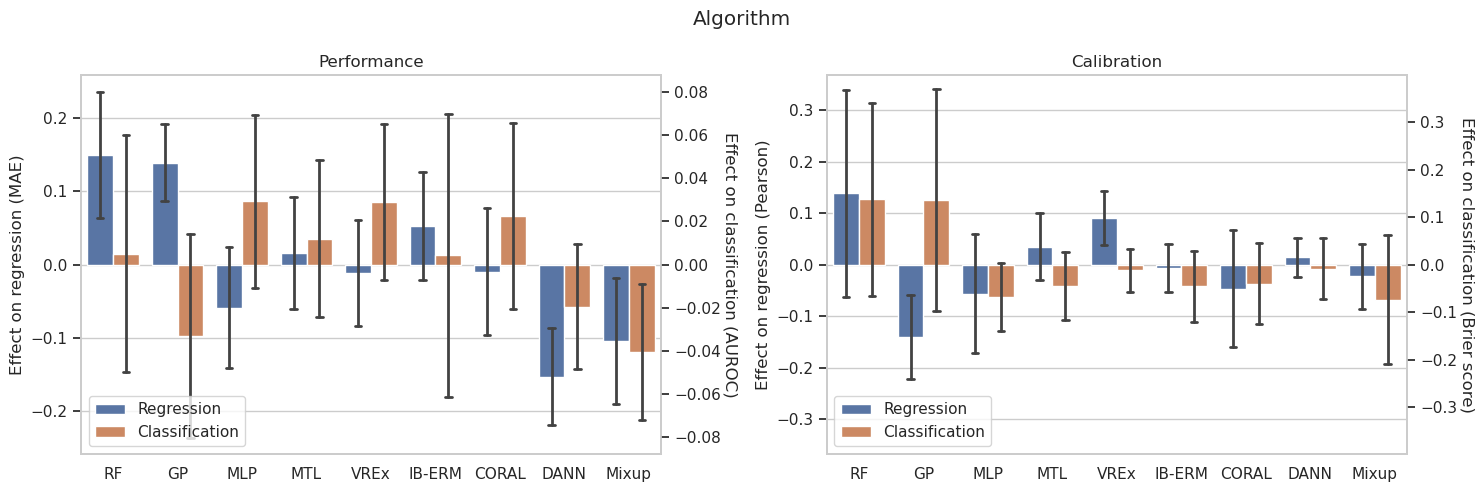

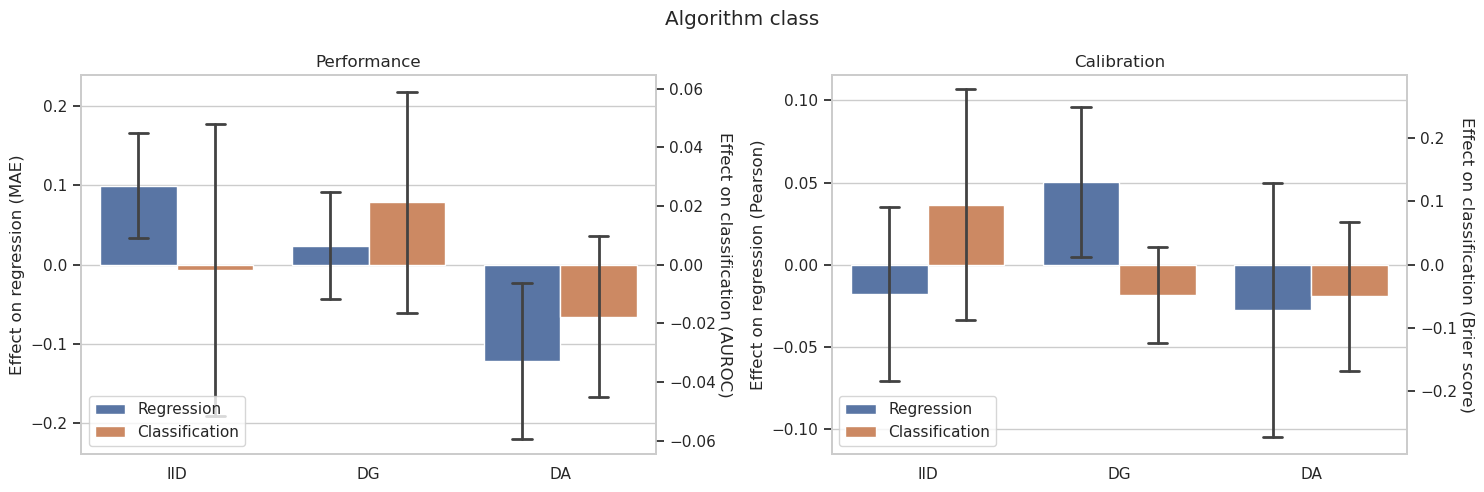

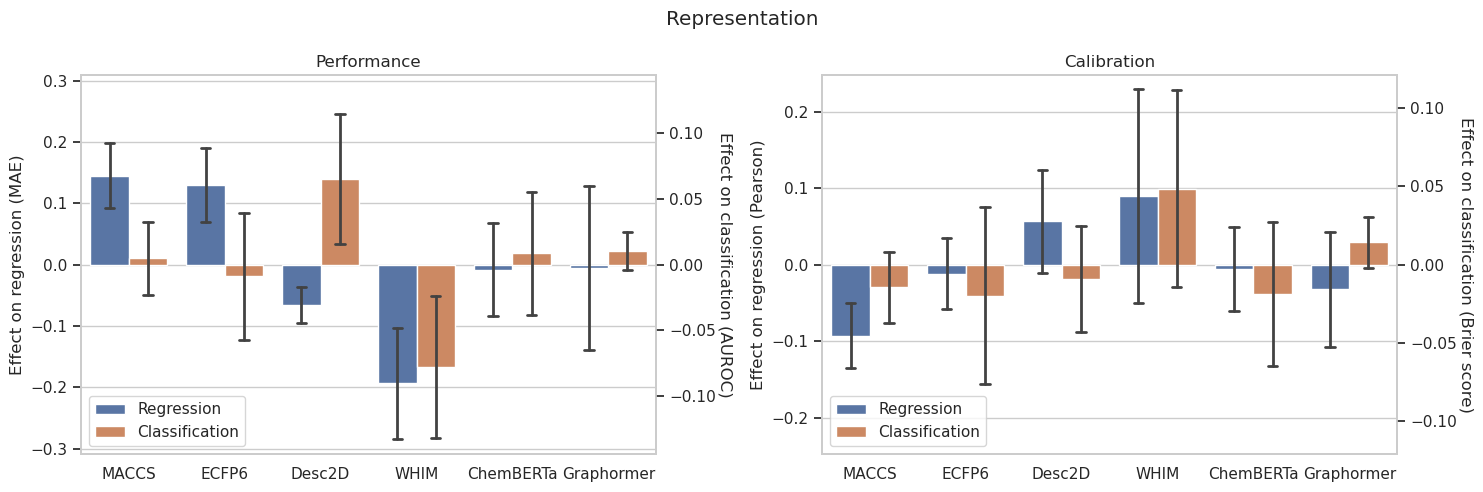

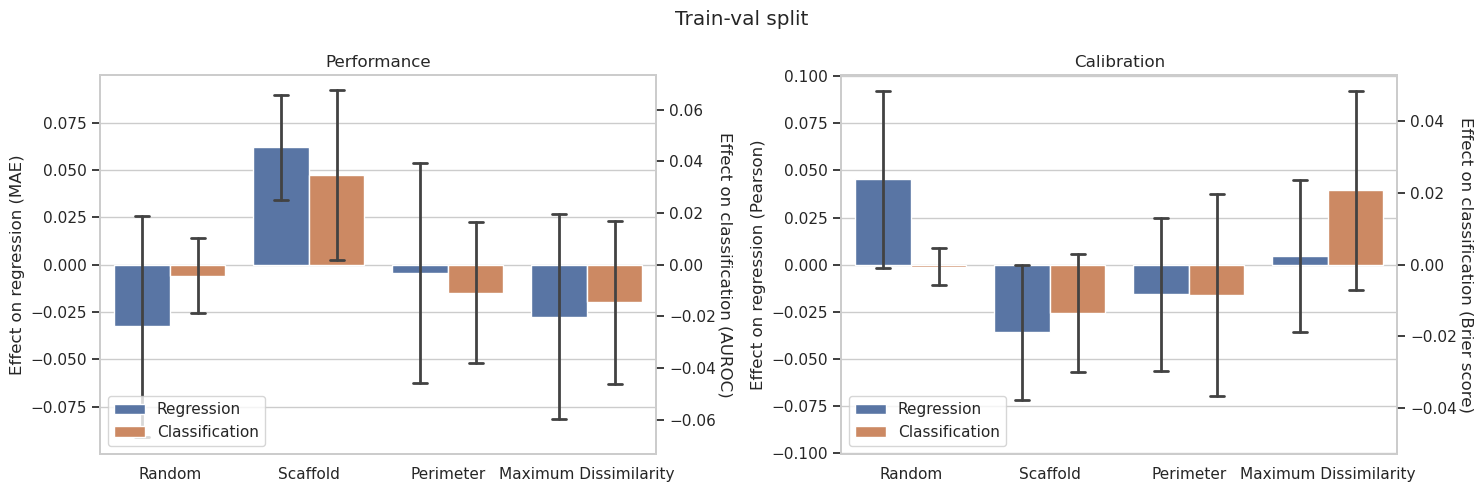

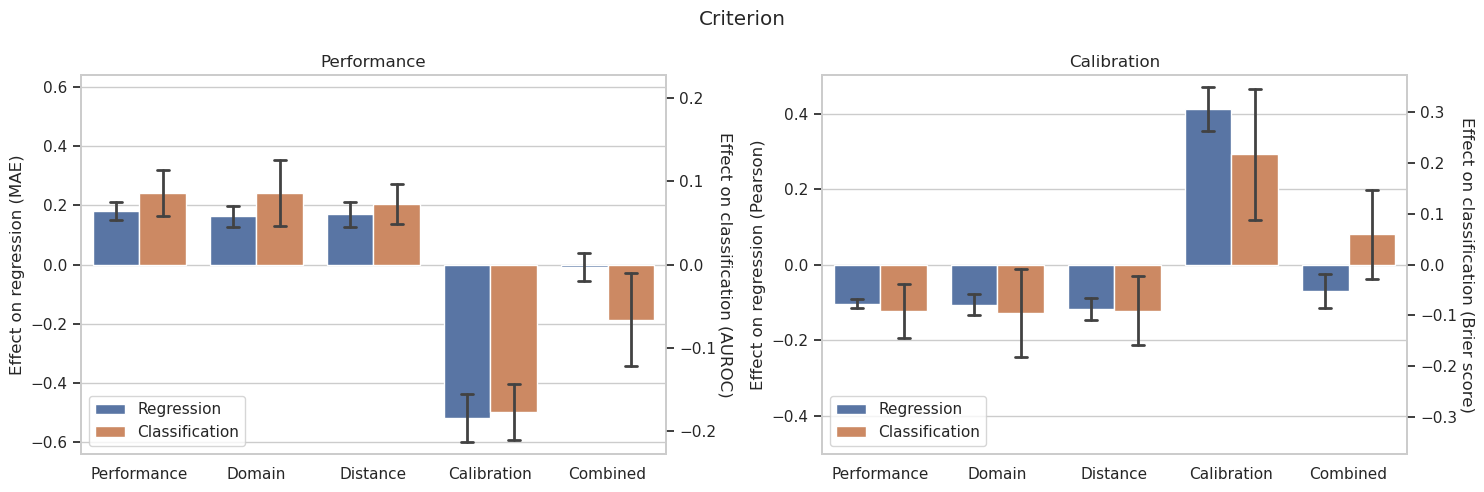

In [10]:
CAT_TO_RENAME = {
    "criterion": {
        "Domain Weighted Performance": "Domain",
        "Distance Weighted Performance": "Distance",
        "Calibration": "Calibration",
        "Performance": "Performance",
        "Calibration x Performance": "Combined"
    },
}


CAT_TO_ORDERING = {
    "algorithm": MOOD_ALGORITHMS,
    "representation": MOOD_REPRESENTATIONS,
    "criterion": MOOD_CRITERIA,
    "train_val_split": MOOD_SPLITTERS,
    "algorithm_class": ["IID", "DG", "DA"],
}

CAT_TO_TITLE = {
    "algorithm": "Algorithm",
    "representation": "Representation",
    "criterion": "Criterion",
    "train_val_split": "Train-val split",
    "algorithm_class": "Algorithm class"
}


def plot_single(df, category, is_calibration, ax_regression, cmap, metrics):
    
    ax_classification = ax_regression.twinx()
    
    diffs = relative_diff_for_category(df, category, is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs["task_type"] =  diffs["dataset"].apply(lambda x: "regression" if x in MOOD_REGR_DATASETS else "classification")
    
    for idx, (task_type, ax) in enumerate(zip(["regression", "classification"], [ax_regression, ax_classification])):
        
        data = diffs[diffs["task_type"] == task_type]
        sns.barplot(
            data=data, 
            x="x", 
            y="delta", 
            errorbar="sd", 
            capsize=0.1, 
            errwidth=2, 
            palette=cmap,
            ax=ax, 
            hue="task_type", 
            dodge=True,
            hue_order=["regression", "classification"], 
            order=CAT_TO_ORDERING[category]
        )
        
        low, high = ax.get_ylim()
        bound = max(abs(low), abs(high))
        ax.set_ylim(-bound, bound)
        ax.legend().remove()
        
    ax.set_title("Calibration" if is_calibration else "Performance")
    
    legend = ax_classification.legend(loc="lower left")
    legend.get_texts()[0].set_text("Regression")
    legend.get_texts()[1].set_text("Classification")
    
    ax_classification.grid(visible=False)
    ax_regression.set_xlabel("")
    
    rename = CAT_TO_RENAME.get(category, {})
    labels = ax_regression.get_xticklabels()
    labels = [rename.get(label.get_text(), label.get_text()) for label in labels]
    ax_regression.set_xticklabels(labels, fontsize=11)
    
    ax_classification.set_ylabel(f"Effect on classification ({metrics[1]})", rotation=270, labelpad=12)
    ax_regression.set_ylabel(f"Effect on regression ({metrics[0]})")


def plot(df):
    df = df.copy()
    
    sns.set_theme(style="whitegrid")
    cmap = sns.color_palette()
    
    for category in ["algorithm", "algorithm_class", "representation", "train_val_split", "criterion"]:
        
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
        for icol, is_calibration in enumerate([False, True]):
            
            if is_calibration:
                metrics = ("Pearson", "Brier score")
            else:
                metrics = ("MAE", "AUROC")
            
            plot_single(df, category, is_calibration, axs[icol], cmap=cmap, metrics=metrics)
        
        fig.suptitle(CAT_TO_TITLE[category])
        plt.tight_layout()

    
plot(df_original)

## Comparing tools

In [11]:
def get_tool_importance(df, is_calibration, is_regression):
    importances = {}
    
    mask = df["dataset"].isin(MOOD_REGR_DATASETS)
    if not is_regression:
        mask = ~mask
    df = df[mask]
    
    for idx, category in enumerate(["algorithm", "algorithm_class", "representation", "train_val_split", "criterion", "seed"]):
        diffs = relative_diff_for_category(df, category, is_calibration)
        diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
        diffs = diffs.groupby("x").mean()["delta"]

        importance = diffs.std()
        importances[category] = importance

    importances = {k: v / importances["seed"] for k, v in importances.items()}
    return importances

### Regression

In [12]:
# Performance
get_tool_importance(df_original, False, True)

{'algorithm': 1.7412423814305529,
 'algorithm_class': 1.9188165391279164,
 'representation': 2.1623021117083807,
 'train_val_split': 0.7443972879619272,
 'criterion': 5.10462536384351,
 'seed': 1.0}

In [13]:
# Calibration
get_tool_importance(df_original, True, True)

{'algorithm': 1.8391102817893532,
 'algorithm_class': 0.9507371832674991,
 'representation': 1.4499027474009616,
 'train_val_split': 0.7739286908840167,
 'criterion': 5.110110699096064,
 'seed': 1.0}

### Classification

In [14]:
# Performance
get_tool_importance(df_original, False, False)

{'algorithm': 1.6715194471975452,
 'algorithm_class': 1.2497674614296466,
 'representation': 2.945980498245623,
 'train_val_split': 1.4509687144577277,
 'criterion': 7.565175599754614,
 'seed': 1.0}

In [15]:
# Calibration
get_tool_importance(df_original, True, False)

{'algorithm': 3.8604698197520744,
 'algorithm_class': 3.948020180797481,
 'representation': 1.2711428833873013,
 'train_val_split': 0.7118456828316011,
 'criterion': 6.534504664769314,
 'seed': 1.0}

# Recompute criteria importance without outlier

In [16]:
def get_criterion_importance(df, is_calibration, is_regression):
    importances = {}
    
    mask = df["dataset"].isin(MOOD_REGR_DATASETS)
    if not is_regression:
        mask = ~mask
    df = df[mask]
    
    diffs = relative_diff_for_category(df, "criterion", is_calibration)
    diffs = diffs[~diffs["x"].isin(["Calibration", "Calibration x Performance"])]
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs = diffs.groupby("x").mean()["delta"]
    importance_criterion = diffs.std()
    
    diffs = relative_diff_for_category(df, "seed", is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs = diffs.groupby("x").mean()["delta"]
    importance_seed = diffs.std()

    return importance_criterion / importance_seed

In [17]:
im1 = get_criterion_importance(df_original, True, True)
im2 = get_criterion_importance(df_original, True, False)
im3 = get_criterion_importance(df_original, False, True)
im4 = get_criterion_importance(df_original, False, False)
im1, im2, im3, im4

(0.17408213700547653,
 0.1058016738620561,
 0.159098973674422,
 0.5002209026243153)

The End.